In [1]:


# make local editable packages automatically reload
%load_ext autoreload
%autoreload 2

# Import dependencies
import numpy as np

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = False #core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
from matplotlib_scalebar.scalebar import ScaleBar

%matplotlib inline
from microfilm.colorify import cmaps_def

import tifffile
from skimage.measure import regionprops_table
from skimage.morphology import binary_dilation
from skimage.transform import rotate
import pandas as pd
from scipy.signal import find_peaks
import scienceplots
import matplotlib
plt.style.use(["science", 'nature'])

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True


>>> GPU activated? 0


In [2]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [5]:
masks = tifffile.imread("../../FDAA_width_analysis/segmentation_output/masks.tif")
image = tifffile.imread("../../FDAA_width_analysis/segmentation_output/image.tif")
mask_labels = np.unique(masks)
def n_dilate(bin_image, n):
    for _ in range(n):
        bin_image = binary_dilation(bin_image)
    return bin_image

def smallestbox(a, b):
    r = a.any(1)
    if r.any():
        m,n = a.shape
        c = a.any(0)
        out = a[r.argmax():m-r[::-1].argmax(), c.argmax():n-c[::-1].argmax()]
        b  = b[:,r.argmax():m-r[::-1].argmax(), c.argmax():n-c[::-1].argmax()]
    else:
        out = np.empty((0,0),dtype=bool)
    return out, b

def get_interpeak(z, mask_label):
    b1, b2 = smallestbox(n_dilate(masks == mask_label,10), image)
    _ = smallestbox((masks == mask_label), image)[0]
    orientation = pd.DataFrame(regionprops_table(_*1, properties=["orientation"]))["orientation"][0]
    b1, b2 = rotate(b1, -orientation * 180/np.pi + 90), np.array([rotate(_, -orientation * 180/np.pi + 90) for _ in b2])
    centroid = regionprops_table(b1*1, properties=["centroid"])
    width = int(b2.shape[1]/10)
    
    
    centreline1 = b2[1,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
    centreline2 = b2[3,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
    
    
    centreline1_peaks = find_peaks(centreline1, prominence=0.006)[0]
    centreline2_peaks = find_peaks(centreline2, prominence=0.006)[0]

    if (len(centreline1_peaks) == 2) and (len(centreline2_peaks) == 2):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.plot(centreline1,c="r")
        ax1.scatter(centreline1_peaks, centreline1[centreline1_peaks], c = "r")
        ax1.plot(centreline2,c="b")
        ax1.scatter(centreline2_peaks, centreline2[centreline2_peaks], c = "b")
        #ax1.legend(["red", "blue"])
        ax2.imshow(b2[1])
        ax3.imshow(b2[3])
        plt.tight_layout()
        plt.savefig(f"plots/{str(z).zfill(4)}.png")
        plt.close()
        #print("Red interpeak distance:", np.diff(centreline1_peaks))
        #print("Blue interpeak distance:", np.diff(centreline2_peaks))
        return [z, np.diff(centreline1_peaks)[0], np.diff(centreline2_peaks)[0]]
    

In [6]:
pix_mic_conv = 0.065/1.5

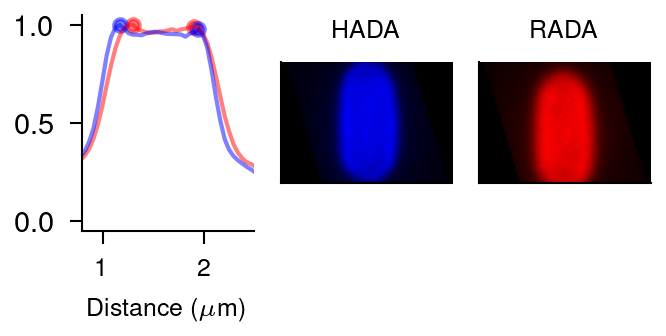

In [8]:
mask_label = 28
b1, b2 = smallestbox(n_dilate(masks == mask_label,10), image)
_ = smallestbox((masks == mask_label), image)[0]
orientation = pd.DataFrame(regionprops_table(_*1, properties=["orientation"]))["orientation"][0]
b1, b2 = rotate(b1, -orientation * 180/np.pi + 90), np.array([rotate(_, -orientation * 180/np.pi + 90) for _ in b2])
centroid = regionprops_table(b1*1, properties=["centroid"])
width = int(b2.shape[1]/10)


centreline1 = b2[1,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
centreline2 = b2[3,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)

centreline1_peaks = find_peaks(centreline1, prominence=0.006)[0]
centreline2_peaks = find_peaks(centreline2, prominence=0.006)[0]
centreline1/=centreline1.max()
centreline2/=centreline2.max()

x_axis = np.arange(len(centreline1))*pix_mic_conv
blue_offset = 2 * pix_mic_conv
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(2.3,1.2))
ax1.plot(x_axis,centreline1,c="r", alpha=0.5)
ax1.scatter(centreline1_peaks*pix_mic_conv , centreline1[centreline1_peaks], c = "r", alpha=0.5)

ax1.plot(x_axis - blue_offset,centreline2,c="b", alpha=0.5)
ax1.scatter(centreline2_peaks*pix_mic_conv - blue_offset, centreline2[centreline2_peaks], c = "b", alpha=0.5)
ax1.set_xlim(0.8,2.5)
ax1.set_xlabel("Distance ($\mu$m)")
#ax1.legend(["red", "blue"])
ax3.imshow(np.rot90(b2[1]**1.5), cmaps_def("pure_red"))
ax2.imshow(np.rot90(b2[3]**1.5), cmaps_def("pure_blue"))
ax2.set_title("HADA")
ax3.set_title("RADA")
for ax in [ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f"{mask_label}.png")

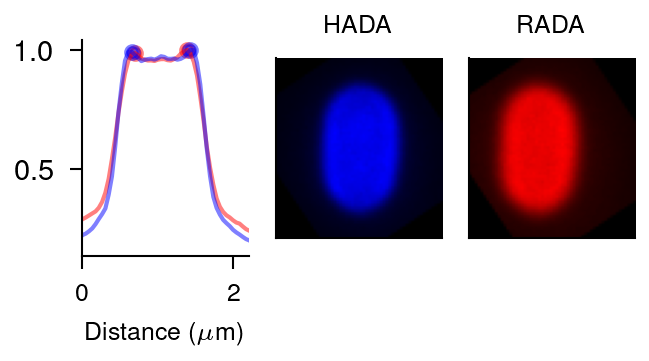

In [9]:
mask_label = 42
b1, b2 = smallestbox(n_dilate(masks == mask_label,10), image)
_ = smallestbox((masks == mask_label), image)[0]
orientation = pd.DataFrame(regionprops_table(_*1, properties=["orientation"]))["orientation"][0]
b1, b2 = rotate(b1, -orientation * 180/np.pi + 90), np.array([rotate(_, -orientation * 180/np.pi + 90) for _ in b2])
centroid = regionprops_table(b1*1, properties=["centroid"])
width = int(b2.shape[1]/10)


centreline1 = b2[1,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
centreline2 = b2[3,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)

centreline1_peaks = find_peaks(centreline1, prominence=0.006)[0]
centreline2_peaks = find_peaks(centreline2, prominence=0.006)[0]
centreline1/=centreline1.max()
centreline2/=centreline2.max()

x_axis = np.arange(len(centreline1))*pix_mic_conv
blue_offset = 5 * pix_mic_conv
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(2.3,1.2))
ax1.plot(x_axis,centreline1,c="r", alpha=0.5)
ax1.scatter(centreline1_peaks*pix_mic_conv , centreline1[centreline1_peaks], c = "r", alpha=0.5)

ax1.plot(x_axis - blue_offset,centreline2,c="b", alpha=0.5)
ax1.scatter(centreline2_peaks*pix_mic_conv - blue_offset, centreline2[centreline2_peaks], c = "b", alpha=0.5)
ax1.set_xlim(0.,2.2)
ax1.set_xlabel("Distance ($\mu$m)")
#ax1.legend(["red", "blue"])
ax3.imshow(np.rot90(b2[1]**1.5), cmaps_def("pure_red"))
ax2.imshow(np.rot90(b2[3]**1.5), cmaps_def("pure_blue"))
ax2.set_title("HADA")
ax3.set_title("RADA")
for ax in [ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f"{mask_label}.png")

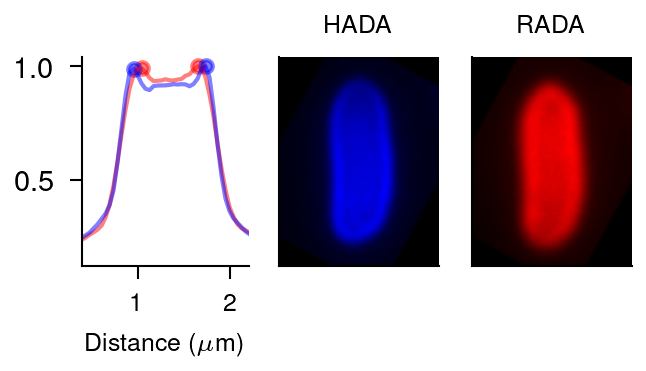

In [10]:
mask_label = 59
b1, b2 = smallestbox(n_dilate(masks == mask_label,10), image)
_ = smallestbox((masks == mask_label), image)[0]
orientation = pd.DataFrame(regionprops_table(_*1, properties=["orientation"]))["orientation"][0]
b1, b2 = rotate(b1, -orientation * 180/np.pi + 90), np.array([rotate(_, -orientation * 180/np.pi + 90) for _ in b2])
centroid = regionprops_table(b1*1, properties=["centroid"])
width = int(b2.shape[1]/10)


centreline1 = b2[1,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
centreline2 = b2[3,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)

centreline1_peaks = find_peaks(centreline1, prominence=0.006)[0]
centreline2_peaks = find_peaks(centreline2, prominence=0.006)[0]
centreline1/=centreline1.max()
centreline2/=centreline2.max()

x_axis = np.arange(len(centreline1))*pix_mic_conv
blue_offset = 1* pix_mic_conv
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(2.3,1.2))
ax1.plot(x_axis,centreline1,c="r", alpha=0.5)
ax1.scatter(centreline1_peaks*pix_mic_conv , centreline1[centreline1_peaks], c = "r", alpha=0.5)

ax1.plot(x_axis - blue_offset,centreline2,c="b", alpha=0.5)
ax1.scatter(centreline2_peaks*pix_mic_conv - blue_offset, centreline2[centreline2_peaks], c = "b", alpha=0.5)
ax1.set_xlim(0.4,2.2)
ax1.set_xlabel("Distance ($\mu$m)")
#ax1.legend(["red", "blue"])
ax3.imshow(np.rot90(b2[1]**1.5), cmaps_def("pure_red"))
ax2.imshow(np.rot90(b2[3]**1.5), cmaps_def("pure_blue"))
ax2.set_title("HADA")
ax3.set_title("RADA")
for ax in [ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f"{mask_label}.png")

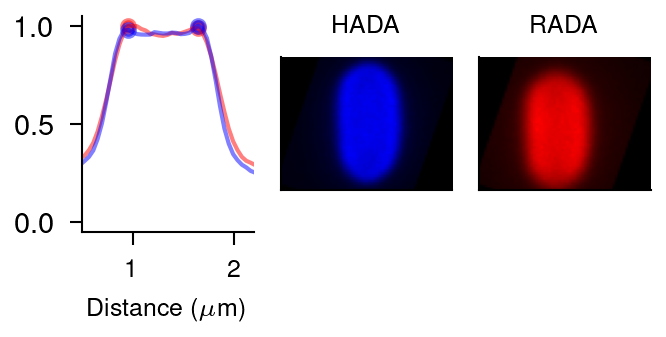

In [11]:
mask_label = 72
b1, b2 = smallestbox(n_dilate(masks == mask_label,10), image)
_ = smallestbox((masks == mask_label), image)[0]
orientation = pd.DataFrame(regionprops_table(_*1, properties=["orientation"]))["orientation"][0]
b1, b2 = rotate(b1, -orientation * 180/np.pi + 90), np.array([rotate(_, -orientation * 180/np.pi + 90) for _ in b2])
centroid = regionprops_table(b1*1, properties=["centroid"])
width = int(b2.shape[1]/10)


centreline1 = b2[1,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
centreline2 = b2[3,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)

centreline1_peaks = find_peaks(centreline1, prominence=0.006)[0]
centreline2_peaks = find_peaks(centreline2, prominence=0.006)[0]
centreline1/=centreline1.max()
centreline2/=centreline2.max()

x_axis = np.arange(len(centreline1))*pix_mic_conv
blue_offset = 4* pix_mic_conv

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(2.3,1.2))
ax1.plot(x_axis,centreline1,c="r", alpha=0.5)
ax1.scatter(centreline1_peaks*pix_mic_conv , centreline1[centreline1_peaks], c = "r", alpha=0.5)

ax1.plot(x_axis - blue_offset,centreline2,c="b", alpha=0.5)
ax1.scatter(centreline2_peaks*pix_mic_conv - blue_offset, centreline2[centreline2_peaks], c = "b", alpha=0.5)
ax1.set_xlim(0.5,2.2)
ax1.set_xlabel("Distance ($\mu$m)")
#ax1.legend(["red", "blue"])
ax3.imshow(np.rot90(b2[1]**1.5), cmaps_def("pure_red"))
ax2.imshow(np.rot90(b2[3]**1.5), cmaps_def("pure_blue"))
ax2.set_title("HADA")
ax3.set_title("RADA")
for ax in [ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f"{mask_label}.png")

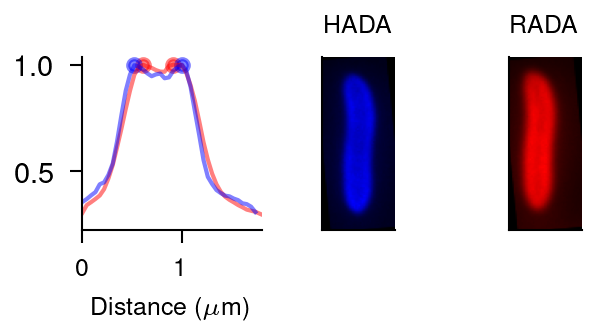

In [12]:
mask_label = 76
b1, b2 = smallestbox(n_dilate(masks == mask_label,10), image)
_ = smallestbox((masks == mask_label), image)[0]
orientation = pd.DataFrame(regionprops_table(_*1, properties=["orientation"]))["orientation"][0]
b1, b2 = rotate(b1, -orientation * 180/np.pi + 90), np.array([rotate(_, -orientation * 180/np.pi + 90) for _ in b2])
centroid = regionprops_table(b1*1, properties=["centroid"])
width = int(b2.shape[1]/10)


centreline1 = b2[1,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
centreline2 = b2[3,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)

centreline1_peaks = find_peaks(centreline1, prominence=0.006)[0]
centreline2_peaks = find_peaks(centreline2, prominence=0.006)[0]
centreline1/=centreline1.max()
centreline2/=centreline2.max()

x_axis = np.arange(len(centreline1))*pix_mic_conv
blue_offset = 5* pix_mic_conv

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(2.3,1.2))
ax1.plot(x_axis,centreline1,c="r", alpha=0.5)
ax1.scatter(centreline1_peaks*pix_mic_conv , centreline1[centreline1_peaks], c = "r", alpha=0.5)

ax1.plot(x_axis - blue_offset,centreline2,c="b", alpha=0.5)
ax1.scatter(centreline2_peaks*pix_mic_conv - blue_offset, centreline2[centreline2_peaks], c = "b", alpha=0.5)
ax1.set_xlim(0.,1.8)
ax1.set_xlabel("Distance ($\mu$m)")
#ax1.legend(["red", "blue"])
ax3.imshow(np.rot90(b2[1]**1.5), cmaps_def("pure_red"))
ax2.imshow(np.rot90(b2[3]**1.5), cmaps_def("pure_blue"))
ax2.set_title("HADA")
ax3.set_title("RADA")
for ax in [ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f"{mask_label}.png")

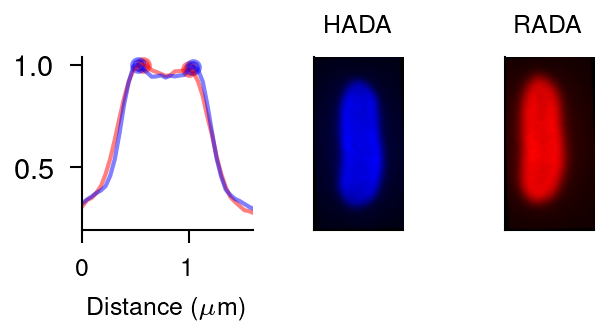

In [13]:
mask_label = 87
b1, b2 = smallestbox(n_dilate(masks == mask_label,10), image)
_ = smallestbox((masks == mask_label), image)[0]
orientation = pd.DataFrame(regionprops_table(_*1, properties=["orientation"]))["orientation"][0]
b1, b2 = rotate(b1, -orientation * 180/np.pi + 90), np.array([rotate(_, -orientation * 180/np.pi + 90) for _ in b2])
centroid = regionprops_table(b1*1, properties=["centroid"])
width = int(b2.shape[1]/10)


centreline1 = b2[1,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
centreline2 = b2[3,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)

centreline1_peaks = find_peaks(centreline1, prominence=0.006)[0]
centreline2_peaks = find_peaks(centreline2, prominence=0.006)[0]
centreline1/=centreline1.max()
centreline2/=centreline2.max()

x_axis = np.arange(len(centreline1))*pix_mic_conv
blue_offset = 4* pix_mic_conv

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(2.3,1.2))
ax1.plot(x_axis,centreline1,c="r", alpha=0.5)
ax1.scatter(centreline1_peaks*pix_mic_conv , centreline1[centreline1_peaks], c = "r", alpha=0.5)

ax1.plot(x_axis - blue_offset,centreline2,c="b", alpha=0.5)
ax1.scatter(centreline2_peaks*pix_mic_conv - blue_offset, centreline2[centreline2_peaks], c = "b", alpha=0.5)
ax1.set_xlim(0.,1.6)
ax1.set_xlabel("Distance ($\mu$m)")
ax3.imshow(np.rot90(b2[1]**1.5), cmaps_def("pure_red"))
ax2.imshow(np.rot90(b2[3]**1.5), cmaps_def("pure_blue"))
ax2.set_title("HADA")
ax3.set_title("RADA")
for ax in [ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

plt.savefig(f"{mask_label}.png")

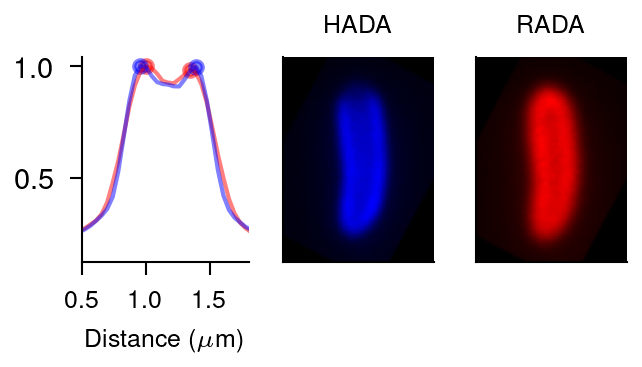

In [14]:
mask_label = 95
b1, b2 = smallestbox(n_dilate(masks == mask_label,10), image)
_ = smallestbox((masks == mask_label), image)[0]
orientation = pd.DataFrame(regionprops_table(_*1, properties=["orientation"]))["orientation"][0]
b1, b2 = rotate(b1, -orientation * 180/np.pi + 90), np.array([rotate(_, -orientation * 180/np.pi + 90) for _ in b2])
centroid = regionprops_table(b1*1, properties=["centroid"])
width = int(b2.shape[1]/10)


centreline1 = b2[1,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
centreline2 = b2[3,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)

centreline1_peaks = find_peaks(centreline1, prominence=0.006)[0]
centreline2_peaks = find_peaks(centreline2, prominence=0.006)[0]
centreline1/=centreline1.max()
centreline2/=centreline2.max()

x_axis = np.arange(len(centreline1))*pix_mic_conv
blue_offset = 1* pix_mic_conv

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(2.3,1.2))
ax1.plot(x_axis,centreline1,c="r", alpha=0.5)
ax1.scatter(centreline1_peaks*pix_mic_conv , centreline1[centreline1_peaks], c = "r", alpha=0.5)

ax1.plot(x_axis - blue_offset,centreline2,c="b", alpha=0.5)
ax1.scatter(centreline2_peaks*pix_mic_conv - blue_offset, centreline2[centreline2_peaks], c = "b", alpha=0.5)
ax1.set_xlim(0.5,1.8)
ax1.set_xlabel("Distance ($\mu$m)")
#ax1.legend(["red", "blue"])
ax3.imshow(np.rot90(b2[1]**1.5), cmaps_def("pure_red"))
ax2.imshow(np.rot90(b2[3]**1.5), cmaps_def("pure_blue"))
ax2.set_title("HADA")
ax3.set_title("RADA")
for ax in [ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f"{mask_label}.png")

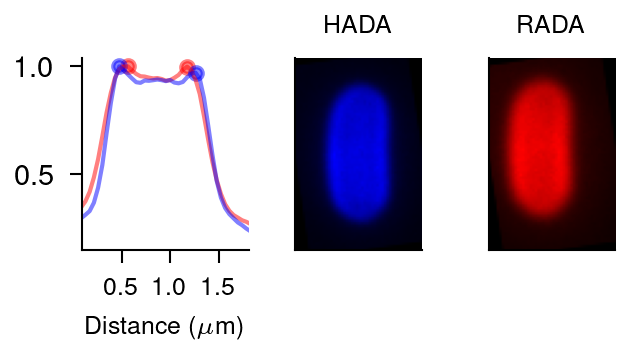

In [15]:
mask_label = 130
b1, b2 = smallestbox(n_dilate(masks == mask_label,10), image)
_ = smallestbox((masks == mask_label), image)[0]
orientation = pd.DataFrame(regionprops_table(_*1, properties=["orientation"]))["orientation"][0]
b1, b2 = rotate(b1, -orientation * 180/np.pi + 90), np.array([rotate(_, -orientation * 180/np.pi + 90) for _ in b2])
centroid = regionprops_table(b1*1, properties=["centroid"])
width = int(b2.shape[1]/10)


centreline1 = b2[1,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
centreline2 = b2[3,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)

centreline1_peaks = find_peaks(centreline1, prominence=0.006)[0]
centreline2_peaks = find_peaks(centreline2, prominence=0.006)[0]
centreline1/=centreline1.max()
centreline2/=centreline2.max()

x_axis = np.arange(len(centreline1))*pix_mic_conv
blue_offset = 4* pix_mic_conv

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(2.3,1.2))
ax1.plot(x_axis,centreline1,c="r", alpha=0.5)
ax1.scatter(centreline1_peaks*pix_mic_conv , centreline1[centreline1_peaks], c = "r", alpha=0.5)

ax1.plot(x_axis - blue_offset,centreline2,c="b", alpha=0.5)
ax1.scatter(centreline2_peaks*pix_mic_conv - blue_offset, centreline2[centreline2_peaks], c = "b", alpha=0.5)
ax1.set_xlim(0.1,1.8)
ax1.set_xlabel("Distance ($\mu$m)")
#ax1.legend(["red", "blue"])
ax3.imshow(np.rot90(b2[1]**1.5), cmaps_def("pure_red"))
ax2.imshow(np.rot90(b2[3]**1.5), cmaps_def("pure_blue"))
ax2.set_title("HADA")
ax3.set_title("RADA")

for ax in [ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f"{mask_label}.png")